In [675]:
import os
os.chdir('/Users/fair00542/Desktop/DC Image Analysis/DC-project-master/cleancode')
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
%matplotlib inline
import plotly 
plotly.offline.init_notebook_mode()
import findeyes
import nibabel as nib
import core
import SimpleITK as sitk

In [676]:
paths = ['/Volumes/SINEADUSB/Scans/ScanB/1.3.12.2.1107.5.1.4.51967.30000014110308064564000003547.dcm', 
        '/Users/fair00542/Desktop/DC Image Analysis/Sinead/DC-Project-Images/original/SampleG/SG_Post-op.nrrd',
        '/Volumes/SINEADUSB/Scans/ScanD/1.3.12.2.1107.5.1.4.95198.30000015040208110913600035431.dcm',
        '/Volumes/SINEADUSB/Scans/ScanE/1.3.12.2.1107.5.1.4.95198.30000015040208110913600035427.dcm',
        '/Volumes/SINEADUSB/Scans/ScanF/1.3.12.2.1107.5.1.4.95198.30000015061008243097400047435.dcm',
        '/Volumes/SINEADUSB/Scans/ScanG/1.3.12.2.1107.5.1.4.95198.30000015051507521609300034665.dcm',
        '/Volumes/SINEADUSB/Scans/ScanH/1.3.12.2.1107.5.1.4.95198.30000015072708211605400036461.dcm',
        '/Volumes/SINEADUSB/Scans/ScanI/1.3.12.2.1107.5.1.4.95198.30000015071109310409300075672.dcm',
        '/Volumes/SINEADUSB/Scans/ScanJ/1.2.392.200036.9116.2.6.1.48.1221600807.1432222434.802585.dcm']


In [677]:
path = paths[1]
scaninfo = []
path

'/Users/fair00542/Desktop/DC Image Analysis/Sinead/DC-Project-Images/original/SampleG/SG_Post-op.nrrd'

In [684]:
# for i in range(len(paths)):
#     path = paths[i]

if path.endswith('.nii') or path.endswith('.nii.gz'):
    array, ConstPixelSpacing, affine = core.nifti2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)
    # visual     = core.thresholdnp(self.scan.array, -100, 1500)

elif path.endswith('.dcm'):
    array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
    bone = core.thresholdnp(array, 900, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

elif path.endswith('.nrrd'):
    array, ConstPixelSpacing, affine = core.nrrd2np(path)
    #array=np.swapaxes(array1, 0, 1)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

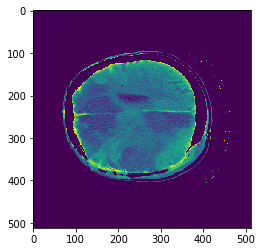

In [685]:
plt.imshow(softtissue[:,:,20])

In [686]:
# Reshaping to make 1voxel volume of 1mm3
boneReshaped = core.reshape(bone, ConstPixelSpacing)
softtissueReshaped = core.reshape(softtissue, ConstPixelSpacing)

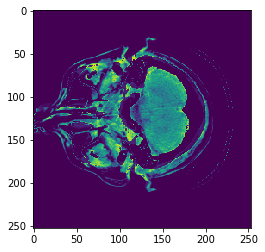

In [687]:
plt.imshow(softtissueReshaped[:,:,20])

In [688]:
H, edges, histData2 = findeyes.hist3dAll(softtissueReshaped)
firstEyeRange, secondEyeRange, certainty  = findeyes.ranges(H,edges)
c1Reshaped, c2Reshaped = findeyes.coords(histData2, firstEyeRange, secondEyeRange)


Optimization terminated successfully.
         Current function value: -62.523334
         Iterations: 40
         Function evaluations: 80


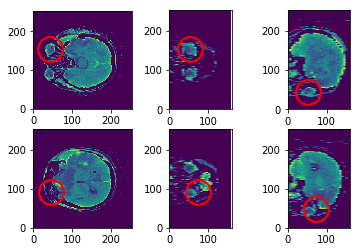

(array([ 153.83333333,   43.66666667,   52.83333333]), array([ 91.43181818,  47.20454545,  73.36363636]))


In [689]:
findeyes.checkcoords(c1Reshaped,c2Reshaped,softtissueReshaped)
print(c1Reshaped,c2Reshaped)

In [690]:
cc = 0.5*(c1Reshaped + c2Reshaped)
xcoord = cc[1]
ycoord = cc[0]
c1, c2 = np.divide(c1Reshaped, ConstPixelSpacing), np.divide(c2Reshaped, ConstPixelSpacing)
# upper half 
if xcoord>=boneReshaped.shape[0]/2:
    if c1[1]<c2[1]: # x coords of c1
        pass 
    else: #exchange c2Reshaped and c1Reshaped
        temp = c2Reshaped
        c2Reshaped = c1Reshaped
        c1Reshaped = temp
# lower half 
else:
    if c1[1]>c2[1]: # x coords of c1
        temp = c2Reshaped
        c2Reshaped = c1Reshaped
        c1Reshaped = temp 
    else: 
        pass
    
#findeyes.checkcoords(c1,c2,array)

cc1 = np.array([c1Reshaped[1], c1Reshaped[0], c1Reshaped[2]])
c1Reshaped = cc1
cc2 = np.array([c2Reshaped[1], c2Reshaped[0], c2Reshaped[2]])
c2Reshaped = cc2
ccReshaped = 0.5*(cc1+cc2)

## angle1(eyeline and z axis) angle2(eyeline and x axis)
angle1, angle2 = findeyes.anglesFromEyes(c1Reshaped, c2Reshaped, boneReshaped.shape)

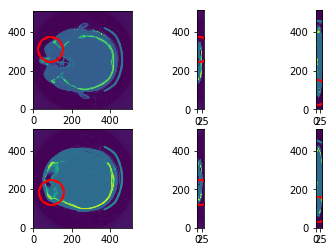

(108.18409931457083, 18.46171868003907)


In [691]:
findeyes.checkcoords(c1,c2,array)
print(angle1,angle2)

In [692]:
c1 = np.divide(c1Reshaped, np.array(ConstPixelSpacing))
c2 = np.divide(c2Reshaped, np.array(ConstPixelSpacing))

In [693]:
from scipy.ndimage.interpolation import rotate
angle2rad = 2*np.pi*angle2/360.
rotAngle = np.sin(angle2rad)*angle1-90

In [694]:
print(rotAngle, angle2)

(-55.741235538238129, 18.46171868003907)


In [695]:
while rotAngle<=-45: #skews are never that big
    rotAngle = rotAngle+90 
    
rotatedSofttissue1 = rotate(softtissueReshaped, angle2, mode='nearest', axes=(0,1)) # want angle1 to be 90
rotatedSofttissue = rotate(rotatedSofttissue1, rotAngle, mode='nearest', axes=(0,2))

rotatedBone1 = rotate(boneReshaped, angle2, mode='nearest', axes=(0,1)) # want angle1 to be 90
rotatedBone = rotate(rotatedBone1, rotAngle, mode='nearest', axes=(0,2))

In [696]:
# Find Eyes Again

H, edges, histData2 = findeyes.hist3dAll(rotatedSofttissue)
firstEyeRange, secondEyeRange, certainty  = findeyes.ranges(H,edges)
c1ReshapedRotated, c2ReshapedRotated = findeyes.coords(histData2, firstEyeRange, secondEyeRange)

Optimization terminated successfully.
         Current function value: -25.064604
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: -27.382301
         Iterations: 38
         Function evaluations: 76


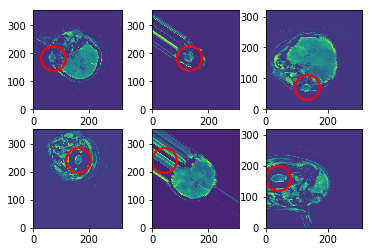

In [697]:
findeyes.checkcoords(c1ReshapedRotated, c2ReshapedRotated, rotatedSofttissue)


In [698]:
angs, xcentroids, ycentroids = core.ellipses(rotatedBone)

slices, sliceAngles = core.selectEllipsesRange(angs)
headx = [xcentroids[i] for i in slices] 
heady = [ycentroids[i] for i in slices] 

a,b,c,d,reshapedNormal = core.findPlaneFromEllipses(rotatedBone, c1ReshapedRotated, c2ReshapedRotated, slices, headx, heady, sliceAngles)


Using eyes to find midplane, as ellipses were unreliable 



<IPython.core.display.Javascript object>


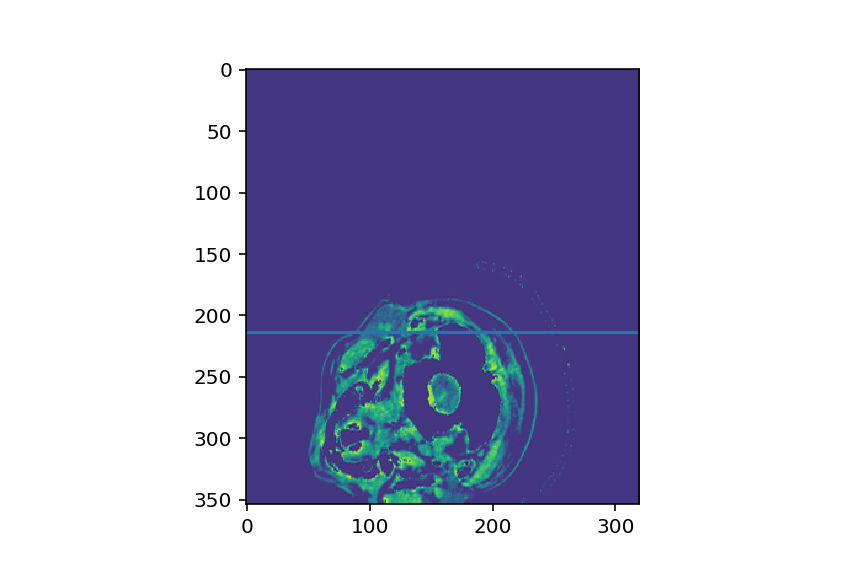

In [699]:
# # Plot original midplane
i = 10

% matplotlib nbagg
x = np.linspace(0,rotatedSofttissue[:,:,i].shape[0], 2)
y = (d-c*i-a*x)/b
plt.plot(x,y, )
plt.imshow(rotatedSofttissue[:,:,i])
plt.ion()

In [257]:
# # Plot original midplane
#i = 100
#% matplotlib nbagg
#x = np.linspace(0,boneReshaped[:,i,:].shape[0], 2)
#z = (d-b*y-a*i)/c
#plt.plot(x,z, )
#plt.imshow(boneReshaped[:,i,:])
#plt.ion()

In [258]:
# % matplotlib nbagg
# i = 150
# y = np.linspace(0,bone[i,:,:].shape[1], 2)
# z = (d-b*y-a*i)/c
# plt.plot(z,y, )
# plt.imshow(softtissueReshaped[i,:,:])
# plt.ion()

In [663]:
import scipy
def f(params, args):
    
    a,b,c,d,e,f,h,i,j = params
    vector =  args[0][0]
    comparison = args[1][0]

    T = np.asarray([[a, b, c],
                    [d, e, f],
                    [h, i, j]])
    
    v1 = np.dot(T, vector)
    
    v2 = comparison
    diff = np.linalg.norm(v1-v2)
    return diff

crr = (c1ReshapedRotated-c2ReshapedRotated)
crr = [crr[1], crr[0], crr[2]]

cr = (c1Reshaped-c2Reshaped)

c = np.divide(cr, ConstPixelSpacing)

x = scipy.optimize.minimize(f,([1,0,0,0,1,0,0,0,1]), args=([[crr], [cr]]))

In [664]:
a,b,c,d,e,f,h,i,j = x.x

T = np.asarray([[a, b, c],
                [d, e, f],
                [h, i, j]])

In [665]:
np.dot(T, crr), cr

(array([ -3.53787885,  62.40151538, -20.53030313]),
 array([ -3.53787879,  62.40151515, -20.53030303]))

In [666]:
normal = np.dot(T, reshapedNormal)
normal = np.divide(normal, np.linalg.norm(normal))
print(normal)

[-0.33242494  0.8347475   0.438965  ]


In [667]:
a,b,c = normal
coord = 0.5*(c1+c2)
d = np.dot(normal, coord)
a,b,c,d

(-0.33242494056978333,
 0.83474749773141199,
 0.43896500306781006,
 181.91784711074325)

<IPython.core.display.Javascript object>


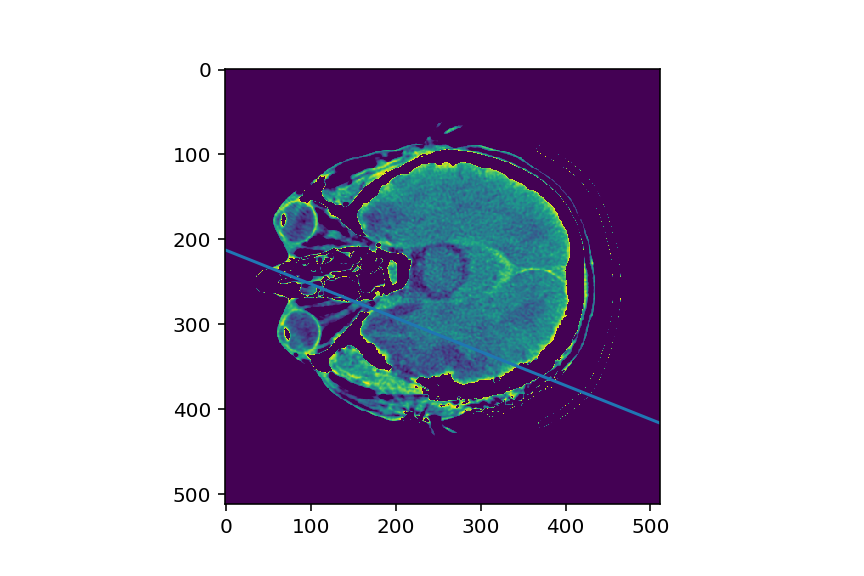

In [668]:
# Plot original midplane
i = 10

% matplotlib nbagg
x = np.linspace(0,bone[:,:,i].shape[0], 2)
y = (d-c*i-a*x)/b
plt.plot(x,y, )
plt.imshow(softtissue[:,:,i])
plt.ion()

In [669]:
crossShape = bone[:,:,i].shape
mask = np.zeros(bone.shape)

if normal[1]>normal[0]:
#if np.argmax(normal)==1:
    print 0
    for i in range(bone.shape[2]):
        z = i
        mask1 = np.fromfunction(lambda x,y: y > (d-c*i-a*x)/b-2, crossShape)
        mask2 = np.fromfunction(lambda x,y: y < (d-c*i-a*x)/b+2, crossShape)
        maski = np.multiply(mask1, mask2)
        mask[:,:,i] = maski
    
if normal[1]<normal[0]:    
#if np.argmax(normal)==0:
    print 1
    for i in range(bone.shape[2]):
        z = i
        mask1 = np.fromfunction(lambda x,y: x > ((d-z*c-y*b)/a-2), crossShape)
        mask2 = np.fromfunction(lambda x,y: x < ((d-z*c-y*b)/a+2), crossShape)
        maski = np.multiply(mask1, mask2)
        mask[:,:,i] = maski

0


In [670]:
print(normal)

[-0.33242494  0.8347475   0.438965  ]


<IPython.core.display.Javascript object>


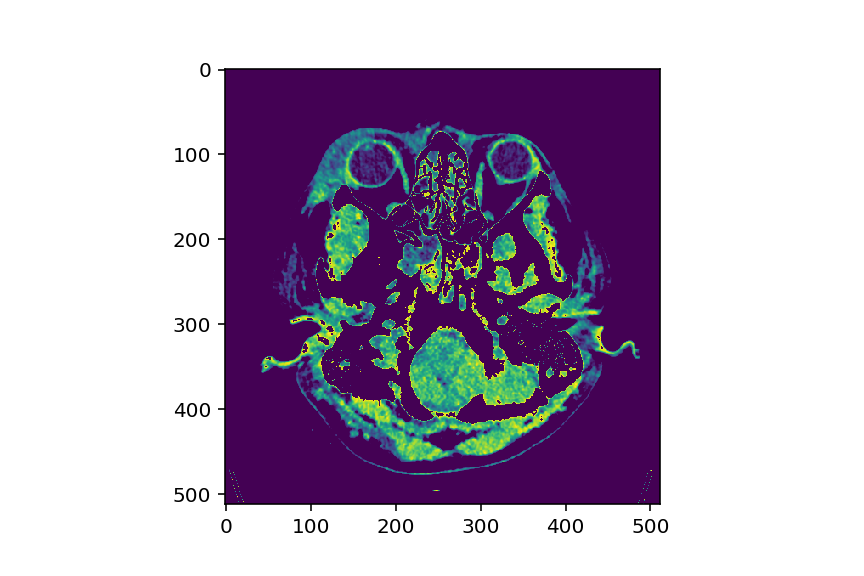

[ 207.414275    411.31014774] [   0.  512.]


In [671]:
# Plot original midplane
i = 20
% matplotlib nbagg
#mask_90 = rotate(mask, -90, mode='nearest', axes=(0,1))
#mask_90 = np.fliplr(mask_90)
x = np.linspace(0,mask[:,:,i].shape[0], 2)
y = (d-c*i-a*x)/b
#plt.plot(y,x,)
plt.imshow(mask[:,:,i])
plt.ion()
print y,x


In [588]:
def saveMask(array, path, name):
    mask = array.astype(np.float64)
    #mask = np.swapaxes(mask, 0, 1)
    img = nib.Nifti1Image(mask, affine)
    savePath = os.path.join(os.path.split(path)[0], '{}.nii.gz'.format(name))
    nib.save(img, savePath)

In [589]:
saveMask(mask, path, 'o')
dirname = os.path.split(os.path.dirname(path))[1]

In [176]:
scaninfo.append((dirname, a,b,c,d))
print(scaninfo)


[('Sample4', -0.12451646714317295, -0.95924367261452215, -0.25366755007132197, -345.79192211959719), ('Sample4', -0.12451646714317295, -0.95924367261452215, -0.25366755007132197, -345.79192211959719), ('Sample4', -0.12451646714317295, -0.95924367261452215, -0.25366755007132197, -345.79192211959719)]


In [174]:
# End

In [2019]:
path

'/Volumes/SINEADUSB/ScanD/1.3.12.2.1107.5.1.4.95198.30000015040208110913600035431.dcm'